# GPyTorch

# 计算Mean
1. zero mean function ```gpytorch.means.ZeroMean()```
2. constant mean function ```gpytorch.means.ConstantMean()```
3. linear mean function ```gpytorch.means.LinearMean()```

# 计算Covariance
1. RBFKernel ```gpytorch.kernels.RBFKernel()```
2. adding a scaling coefficient: ```gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())```

一般会在核函数的输出上添加缩放系数。在核函数的输出上添加缩放系数是为了调整核函数的影响力。  

例如，如果我们希望某个核函数的输出对预测结果的贡献更大，我们可以使用较大的缩放系数。相反，如果我们希望某个核函数的输出对预测结果的贡献较小，我们可以使用较小的缩放系数。  
通过在核函数的输出上应用kernels.ScaleKernel()，我们可以乘以一个固定的缩放因子，以增加或减小核函数的输出。



# exact GP and approximate GP
1. Exact inference applies when the closed-form expression of the posterior is available. 
We can simple and quick to compute the posterior distribution using ```gpytorch.models.ExactGP```.
2. Approximate inference applies when the posterior distribution involves high-dimensional integrals.
It is difficult and time-consuming to compute.  In such cases we use ```gpytorch.models.ApproximateGP```.

### exact GP
$$
f(x) = -\cos(\pi x) + \sin(4 \pi x)
$$

In [6]:
import torch 
import numpy as np
from matplotlib import pyplot as plt

def f(x, noise=0):
    """ 
    objective function
    """
    return -torch.cos(np.pi * x) + torch.sin(4 * np.pi * x) + noise * torch.randn(*x.shape)

tensor([0.0500, 0.1500, 0.2500, 0.3500, 0.4500, 0.5500, 0.6500, 0.7500, 0.8500,
        0.9500])
tensor([-0.3821, -0.0597, -0.7451, -1.4902, -0.6087,  0.7095,  1.2641,  0.7171,
        -0.1037,  0.4382])


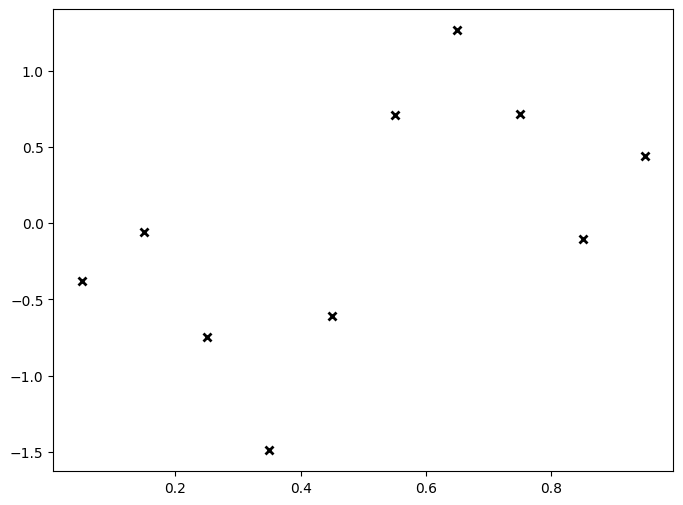

In [18]:
# observation noise
noise = 0.1
# number of observations
N =10
# initial observations upon initiation 生成一个等间距的函数调用
X_init = torch.linspace(0.05,0.95,N) 
y_init = f(X_init, noise)
print(X_init)
print(y_init)
# plot noisy observations
plt.figure(figsize=(8,6))
plt.plot(X_init.numpy(), y_init.numpy(), 'kx', mew=2)

# GPRegressor

概率分布和边缘分布的区别：

1. 概率分布 $p(f | x)$：这是指给定输入变量 $x$ 的情况下，目标变量 $f$ 的概率分布。在监督学习中，我们通常使用概率模型来建模输入与输出之间的关系。$p(f | x)$ 描述了模型对于给定输入 $x$ 的输出 $f$ 的不确定性。常见的例子是高斯过程模型，其中 $p(f | x)$ 是一个高斯分布。
2. 边缘分布 $p(y | x)$：这是指给定输入变量 $x$ 的情况下，目标变量 $y$ 的概率分布。边缘分布是通过对概率分布 $p(f | x)$ 进行积分或求和得到的，其中 $y$ 是通过对 $f$ 进行某种函数变换得到的。在监督学习中，$y$ 通常是观测到的目标变量，而 $f$ 是模型对于给定输入 $x$ 的预测值。

In [1]:
import torch
import numpy as np
import gpytorch
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(1)

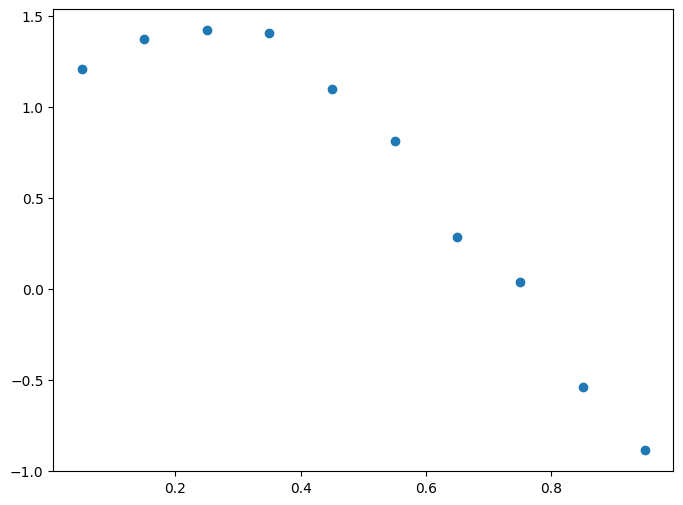

In [2]:
# 定义目标函数
def f(x, noise=0):
    return torch.cos(np.pi*x) + torch.sin(np.pi*x) + noise*torch.randn(*x.shape)
    
# 设置观测噪声
noise = 0.1
# 设置观测个数
N = 10
# 初始化X和Y
X_init = torch.linspace(0.05, 0.95, N)
y_init = f(X_init, noise=noise)
# 画图
plt.figure(figsize=(8, 6))
plt.plot(X_init.numpy(), y_init.numpy(), 'o');

In [3]:
import gpytorch

class GPRegressor(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, mean, kernel, likelihood=None):
        if likelihood is None:
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
        # initiate the superclass ExactGP to refresh the posterior 
        super().__init__(train_inputs, train_targets, likelihood)
        # store attributes
        self.mean = mean
        self.kernel = kernel
        self.likelihood = likelihood
    

    def forward(self, x):
        """
        Return:
            a posterior multivariate normal distribution
        """
        # mean and kernel are stored as attributes
        mean_x = self.mean(x)
        covar_x = self.kernel(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    def predict(self, x):
        """
        compute the marginal predictive distribution of y given x
        """
        # set the model to evaluation mode
        self.eval()
        # perform inference without gradient propagation
        with torch.no_grad():  # 在预测阶段，不需要计算梯度，因为只有前向传播
            # get posterior distribution p(f|x)
            pred = self(x)
            # convert posterior distribution p(f|x) to p(y|x)
            return self.likelihood(pred)

In [5]:
def plot_model(model, xlim = None):
    """
    """
    X_train = model.train_inputs[0].cpu().numpy()
    y_train = model.train_targets.cpu().numpy()


    # obtain range of x axis
    if xlim is None:
        xmin = float(X_train.min())
        xmax = float(X_train.max())
        x_range = xmax - xmin
        xlim = [xmin - 0.05 * x_range, xmax + 0.05 * x_range]


    model_tensor_example = list(model.parameters())[0]  
    print(model_tensor_example)
    # The .to() method is used to specify the target device.
    # .to(model_tensor_example)将张量转换为与 model_tensor_example 张量相同的设备上
    X_plot = torch.linspace(xlim[0],xlim[1], 200).to(model_tensor_example)

    # generate predictive posterior distribution
    model.eval()
    predictive_distribution = model.predict(X_plot)
    # obtain mean, upper and lower bounds   
    lower, upper = predictive_distribution.confidence_region()
    prediction = predictive_distribution.mean.cpu().numpy()
    X_plot = X_plot.numpy()
    # x_train和y_Train都是一维数组或者张量，可以直接用scatter画散点图
    # marker='x'：指定散点的标记形状为 "x"。
    # c='k'：指定散点的颜色为黑色。
    plt.scatter(X_train, y_train, marker='x', c='k')
    # 折线图：接受 X_plot 作为 x 坐标轴的数据，prediction 作为 y 坐标轴的数据，将它们连接起来绘制一条折线。
    plt.plot(X_plot, prediction)
    plt.fill_between(X_plot, lower, upper, alpha=0.1)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)




## Fit GP regression model

Parameter containing:
tensor([0.], requires_grad=True)


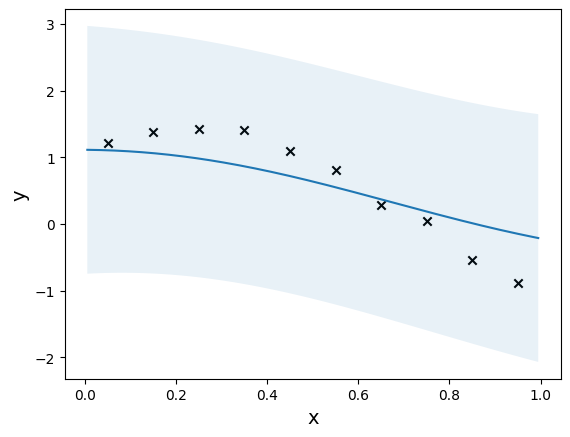

In [6]:
mean_fn = gpytorch.means.ConstantMean()
kernel_fn = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

model = GPRegressor(X_init, y_init, mean_fn, kernel_fn)
plot_model(model)

### Train Model

In [7]:
# fine tune hyperparameters (lengthscale and noise variance) by optimizing MLE
def train(model, X, y, n_epochs=100, lr=0.3, verbose=True):
    # switch to model training mode
    model.train()
    # Use the adam optimizer
    training_parameters = model.parameters()
    optimizer = torch.optim.Adamax(training_parameters, lr=lr)
    # initiate a GP model with Gaussian likelihood for MLL calculation
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    # start the training loop
    for e in range(n_epochs):
        # clear gradients to prevent gradient accumulation
        optimizer.zero_grad()
        # get posterior distribution p(f|x)
        out = model(X)
        # get negated exact marginal log likelihood p(y|x)
        loss = -mll(out, y)
        # caculated gradients using autograd
        loss.backward()
        # perform gradient update
        optimizer.step()
        # print optimization log
        if verbose:
            if e % 5 == 0:
                lengthscale = model.kernel.base_kernel.lengthscale.squeeze(0).detach().cpu().numpy()
                print(f"Epoch: {e}, loss: {loss.item():.3f}, lengthscale: {lengthscale[0]:.3f}, noise: {model.likelihood.noise.item():.3f}")
                # print(f"Loss: {loss.item():.3f}, lengthscale: {lengthscale}")   

In [8]:
train(model, X_init, y_init)

Epoch: 0, loss: 1.147, lengthscale: 0.554, noise: 0.554
Epoch: 5, loss: 0.716, lengthscale: 0.333, noise: 0.168
Epoch: 10, loss: 0.281, lengthscale: 0.460, noise: 0.043
Epoch: 15, loss: -0.092, lengthscale: 0.466, noise: 0.011
Epoch: 20, loss: -0.242, lengthscale: 0.535, noise: 0.004
Epoch: 25, loss: -0.173, lengthscale: 0.573, noise: 0.002
Epoch: 30, loss: -0.208, lengthscale: 0.554, noise: 0.003
Epoch: 35, loss: -0.244, lengthscale: 0.574, noise: 0.005
Epoch: 40, loss: -0.235, lengthscale: 0.556, noise: 0.006
Epoch: 45, loss: -0.235, lengthscale: 0.554, noise: 0.006
Epoch: 50, loss: -0.244, lengthscale: 0.550, noise: 0.005
Epoch: 55, loss: -0.247, lengthscale: 0.542, noise: 0.004
Epoch: 60, loss: -0.245, lengthscale: 0.546, noise: 0.004
Epoch: 65, loss: -0.246, lengthscale: 0.541, noise: 0.004
Epoch: 70, loss: -0.247, lengthscale: 0.544, noise: 0.004
Epoch: 75, loss: -0.247, lengthscale: 0.544, noise: 0.005
Epoch: 80, loss: -0.247, lengthscale: 0.545, noise: 0.005
Epoch: 85, loss: -0

Parameter containing:
tensor([-5.4398], requires_grad=True)


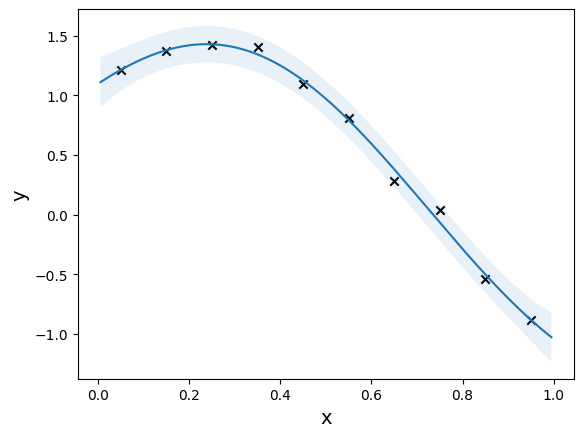

In [9]:
plot_model(model)